# AI model to Detect SIgn Language Alphabets

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import xmltodict
import os

## Creating a label_map for available data

In [2]:
print('{', end=' ')
index = 0
for i in range(65, 91):
    if chr(i) == 'C' or chr(i) == 'J' or chr(i) == 'Y':
        continue
    print(f"'{chr(i)}' : {index},",end=' ')
    index += 1
print('}')

{ 'A' : 0, 'B' : 1, 'D' : 2, 'E' : 3, 'F' : 4, 'G' : 5, 'H' : 6, 'I' : 7, 'K' : 8, 'L' : 9, 'M' : 10, 'N' : 11, 'O' : 12, 'P' : 13, 'Q' : 14, 'R' : 15, 'S' : 16, 'T' : 17, 'U' : 18, 'V' : 19, 'W' : 20, 'X' : 21, 'Z' : 22, }


In [3]:
#label_map = { 'A' : 0, 'B' : 1, 'D' : 2, 'E' : 3, 'F' : 4, 'G' : 5, 'H' : 6, 'I' : 7, 'K' : 8, 'L' : 9, 'M' : 10, 'N' : 11, 'O' : 12, 'P' : 13, 'Q' : 14, 'R' : 15, 'S' : 16, 'T' : 17, 'U' : 18, 'V' : 19, 'W' : 20, 'X' : 21, 'Z' : 22 }
label_map = {'LiveLong': 0, 'ThumbsDown': 1, 'ThumbsUp' : 2}

## Creating a Custom DataSet

In [3]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, transforms = None) -> None:
        self.img_dir = img_dir
        self.annotation_dir = annotations_dir
        self.images = [x for x in os.listdir(img_dir) if x.endswith('.jpg')]
        self.annotations = [x for x in os.listdir(annotations_dir) if x.endswith('.xml')]
        self.transform = transforms
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        annotation_path = os.path.join(self.annotation_dir, self.annotations[index])

        img = Image.open(img_path).convert('RGB')

        with open(annotation_path, "r") as f:
            xml_data = xmltodict.parse(f.read())
        
        objects = xml_data['annotation']['object']

        labels = []
        bndboxes = []

        if type(objects) == list:
            for i in objects:
                labels.append(label_map[str(i['name'])])
                box=i['bndbox']
                bndboxes.append(list(map(int, [box['xmin'], box['ymin'], box['xmax'], box['ymax']])))
        else:
            labels.append(label_map[str(objects['name'])])
            box=objects['bndbox']
            bndboxes.append(list(map(int, [box['xmin'], box['ymin'], box['xmax'], box['ymax']])))

        target = {'labels' : torch.tensor(labels, dtype=torch.int64), 'boxes' : torch.tensor(bndboxes, dtype=torch.float32)}
        
        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self)  ->  int:
        return len(self.images)                

## Customizing the pretrained model

In [12]:
# This is if you havent trained before
model_0 = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model_0.roi_heads.box_predictor.cls_score.in_features
number_of_classes = 3
model_0.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, number_of_classes)

c:\Users\SHANMU\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SHANMU\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# This is if you HAVE trained before
model_0 = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model_0.roi_heads.box_predictor.cls_score.in_features
number_of_classes = 3
model_0.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, number_of_classes)

previous_checkpoint = torch.load('Scaled_model_checkpoint.pth')
model_0.load_state_dict(previous_checkpoint['model_state_dict'])

c:\Users\SHANMU\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SHANMU\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\SHANMU\AppData\Local\Temp\ipykernel_10080\711954771.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `

<All keys matched successfully>

## Defining a Collate Function to Arrange the data correctly

* When we access the batches, we'll get something like this `[(image1, taget1), (image2, target2), (image3, target3), (image4, taget4)]`

* Using a collate function, we can organize our data more efficiently while loading it. So the same data would look like `[(image1, image2, image3, image4), (target1, target2, target3, target4)]` using the following function.

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

## Loading the Datasets

In [6]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()])

In [7]:
train_dataset = CustomDataset('images/train', 'images/train', transforms=transform)
train_dataloader = DataLoader(train_dataset, 2, shuffle=True, collate_fn=collate_fn)

test_dataset = CustomDataset('images/test', 'images/test', transforms=transform)
test_datalaoder = DataLoader(test_dataset, 2, shuffle=True, collate_fn=collate_fn)

## Setting the Model Optimzers and Such

What do we need to do yet:

* Set the optimizer

* Set the hyper parameters

* Send the model to device


In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [16]:
#if this is the first time, then
optimizer = optim.SGD(params = [p for p in model_0.parameters() if p.requires_grad], lr = 0.005, momentum=0.9, weight_decay=0.0005)
epochs = 20

model_0.to(device=device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
optimizer = optim.SGD(params = [p for p in model_0.parameters() if p.requires_grad], lr = 0.005, momentum=0.9, weight_decay=0.0005)
epochs = 20
optimizer.load_state_dict(previous_checkpoint['optimizer_state_dict'])
model_0.to(device=device)
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)


# Let's Get to Training!

In [15]:
scheduler = lr_scheduler.StepLR(optimizer, 10, 0.1)

In [16]:
# best_val_loss = float('inf')
# patience = 3  # Number of epochs to wait before stopping
# trigger_times = 0
epochs = 20
for epoch in range(epochs):
    model_0.train()

    running_loss = 0.0

    for images, targets in train_dataloader:
        image_list = list(image.to(device) for image in images)
        target_list = list({k : v.to(device) for k,v in t.items()} for t in targets)
        
        loss_dict = model_0(image_list, target_list)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
    
    print("In Training mode")
    print(f"epoch : {epoch + 1}/{epochs} | Testing Loss : {running_loss}")
    scheduler.step()
    # model_0.eval()
    # val_loss = 0.0
    # with torch.no_grad():
    #     for images, targets in test_datalaoder:
    #         image_list = list(image.to(device) for image in images)
    #         target_list = list({k : v.to(device) for k,v in t.items()} for t in targets)
    #         loss_dict = model_0(image_list, target_list)
    #         print(type(loss_dict))
    #         losses = sum(loss for loss in loss_dict.values())

    #         val_loss += losses.item()
    #     val_loss /= len(test_datalaoder)
    #     print(f'Epoch {epoch+1} | Validation Loss: {val_loss:.4f}')

    #     if val_loss < best_val_loss:
    #         best_val_loss = val_loss
    #         trigger_times = 0
    #         # Save the best model
    #         torch.save(model_0.state_dict(), 'best_model.pth')
    #     else:
    #         trigger_times += 1
    #         if trigger_times >= patience:
    #             print('Early stopping!')
    #             break

In Training mode
epoch : 1/20 | Testing Loss : 1.7135939341969788
In Training mode
epoch : 2/20 | Testing Loss : 1.6070837564766407
In Training mode
epoch : 3/20 | Testing Loss : 1.580786700360477
In Training mode
epoch : 4/20 | Testing Loss : 1.5051751914434135
In Training mode
epoch : 5/20 | Testing Loss : 1.4786569802090526
In Training mode
epoch : 6/20 | Testing Loss : 1.3052357975393534
In Training mode
epoch : 7/20 | Testing Loss : 1.211036663968116
In Training mode
epoch : 8/20 | Testing Loss : 1.3310411740094423
In Training mode
epoch : 9/20 | Testing Loss : 1.3461827167775482
In Training mode
epoch : 10/20 | Testing Loss : 1.2821083678863943
In Training mode
epoch : 11/20 | Testing Loss : 1.2926683221012354
In Training mode
epoch : 12/20 | Testing Loss : 1.240840162616223
In Training mode
epoch : 13/20 | Testing Loss : 1.339934067800641
In Training mode
epoch : 14/20 | Testing Loss : 1.2690254445187747
In Training mode
epoch : 15/20 | Testing Loss : 1.2854479495435953
In Train

In [35]:
checkpoint = {
    'model_state_dict' : model_0.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict()
}

torch.save(checkpoint, 'Scaled_model_checkpoint.pth')
torch.save(model_0, 'Scaled_full_model.pth')

In [54]:
images_test = []
for i in  [ x for x in os.listdir('datasets/test') if x.endswith('.jpg')]:
    img = Image.open(os.path.join('datasets','test',i)).convert('RGB')
    img = transforms.functional.to_tensor(img).unsqueeze(0).to(device)
    images_test.append(img)



model_0.eval()
results = []
with torch.inference_mode():
    for i in images_test:
        predictions = model_0(i)
        results.append(predictions)
print(results)


[[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}], [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}], [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}], [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}], [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}], [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}], [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:

In [15]:
Image_name = 'IMG20240917192548.jpg'
img = Image.open(os.path.join('images','test',Image_name)).convert('RGB')
img = transforms.functional.to_tensor(img).unsqueeze(0).to(device)
model_0.eval()
with torch.inference_mode():
    pred = model_0(img)

pred[0]

{'boxes': tensor([[ 559.8840, 1017.3771, 2130.5142, 3310.3997],
         [ 845.1040, 1422.3462, 2174.1619, 3446.8088],
         [1814.3081, 1996.8087, 2685.4434, 3561.6951]], device='cuda:0'),
 'labels': tensor([2, 1, 1], device='cuda:0'),
 'scores': tensor([0.8426, 0.3446, 0.0502], device='cuda:0')}

In [16]:
prediction_label_map = {0:'LiveLong', 1:'ThumbsDown',2:'ThumbsUp'}

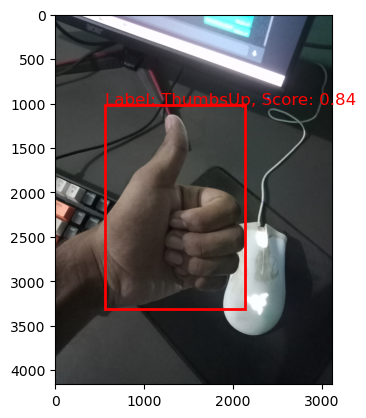

In [17]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches



output = pred[0]
image = Image.open(os.path.join('images','test',Image_name)) 
fig, ax = plt.subplots(1)
ax.imshow(image)
threshold = 0.5

for i, box in enumerate(output['boxes'].to('cpu')):
    score = output['scores'][i].to('cpu').item()
    if score > threshold:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label = output['labels'].to('cpu')[i].item()
        ax.text(x_min, y_min - 10, f'Label: {prediction_label_map[label]}, Score: {score:.2f}', color='red', fontsize=12)

plt.show()
